In [3]:
import numpy as np

# Загружаем сглаженные сигналы
X_train = np.load("X_train_smooth.npy")
X_test = np.load("X_test_smooth.npy")

# Предположим, что метки y_train и y_test тоже у тебя есть
# Если нет — создадим их (если ты не сохранял — напиши, помогу восстановить)
y_train = np.load("y_train.npy")  # должен быть в формате [0, 1, 0, 1, ...]
y_test = np.load("y_test.npy")

In [4]:
import numpy as np
from scipy import stats
from scipy.fft import fft

def extract_features(x):
    """
    Извлекает признаки из одного сигнала x (длина ~65000)
    Возвращает: numpy array формы (N_features,)
    """
    L = len(x)

    # Центральный участок (10% от длины)
    center_len = L // 10
    center_start = L // 2 - center_len // 2
    center_end = center_start + center_len
    center = x[center_start:center_end]

    # Крайние участки (по 5% с каждого края)
    edge_len = L // 20
    left_edge = x[:edge_len]
    right_edge = x[-edge_len:]
    edges = np.concatenate([left_edge, right_edge])

    features = []

    # --- Основные статистики ---
    features.append(np.mean(x))           # среднее
    features.append(np.std(x))            # стандартное отклонение
    features.append(np.max(x))            # максимум
    features.append(np.min(x))            # минимум
    features.append(np.ptp(x))            # размах
    features.append(np.mean(x**2))        # энергия
    features.append(np.mean(np.abs(x)))   # средняя абсолютная амплитуда

    # --- Центральные признаки ---
    features.append(np.mean(center))      # среднее в центре
    features.append(np.std(center))       # дисперсия в центре
    features.append(np.max(center))       # пик в центре
    features.append(np.mean(center**2))   # энергия в центре
    features.append(np.mean(center**2) / (np.mean(edges**2) + 1e-8))  # отношение центр/края

    # --- Дополнительные признаки ---
    features.append(stats.skew(x))        # асимметрия
    features.append(stats.kurtosis(x))    # эксцесс (острота)
    features.append(np.sum(np.abs(np.diff(x)) > 0.1))  # число "скачков" (приблизительно)

    # --- FFT-признаки (для гармоники) ---
    # Берём только первые 100 частот (все слишком много)
    fft_vals = np.abs(fft(x))[:100]
    features.append(np.max(fft_vals))     # доминирующая частота
    features.append(np.mean(fft_vals[1:10]))  # энергия в низких частотах
    features.append(np.mean(fft_vals[10:50])) # средние частоты
    features.append(np.mean(fft_vals[50:100])) # высокие частоты

    return np.array(features)

# Применяем ко всем сигналам
print("Извлечение признаков...")
X_train_feat = np.array([extract_features(x) for x in X_train])
X_test_feat = np.array([extract_features(x) for x in X_test])

print(f"Форма признаков: train={X_train_feat.shape}, test={X_test_feat.shape}")

Извлечение признаков...
Форма признаков: train=(207, 19), test=(53, 19)


In [5]:
feature_names = [
    'mean',        # f0
    'std',         # f1
    'max',         # f2
    'min',         # f3
    'ptp',         # f4
    'energy',      # f5
    'mean_abs',    # f6
    'center_mean', # f7
    'center_std',  # f8
    'center_max',  # f9
    'center_energy', # f10
    'center_vs_edges', # f11
    'skew',        # f12
    'kurtosis',    # f13
    'jumps',       # f14
    'fft_max',     # f15
    'fft_low',     # f16
    'fft_mid',     # f17
    'fft_high'     # f18
]

In [6]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Создаём модель
model = XGBClassifier(
    n_estimators=100,      # число деревьев
    max_depth=4,           # глубина деревьев
    learning_rate=0.1,     # скорость обучения
    random_state=42,
    eval_metric='logloss'  # для бинарной классификации
)

# Обучаем
print("Обучение XGBoost...")
model.fit(X_train_feat, y_train)

# Предсказываем
y_pred = model.predict(X_test_feat)

# Оценка
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
# Сохраняем модель в файл
model.save_model("xgboost_signal_classifier.json")
print("✅ Модель XGBoost сохранена как 'xgboost_signal_classifier.json'")

Обучение XGBoost...

✅ Accuracy: 0.9811

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        26
         1.0       1.00      0.96      0.98        27

    accuracy                           0.98        53
   macro avg       0.98      0.98      0.98        53
weighted avg       0.98      0.98      0.98        53

✅ Модель XGBoost сохранена как 'xgboost_signal_classifier.json'


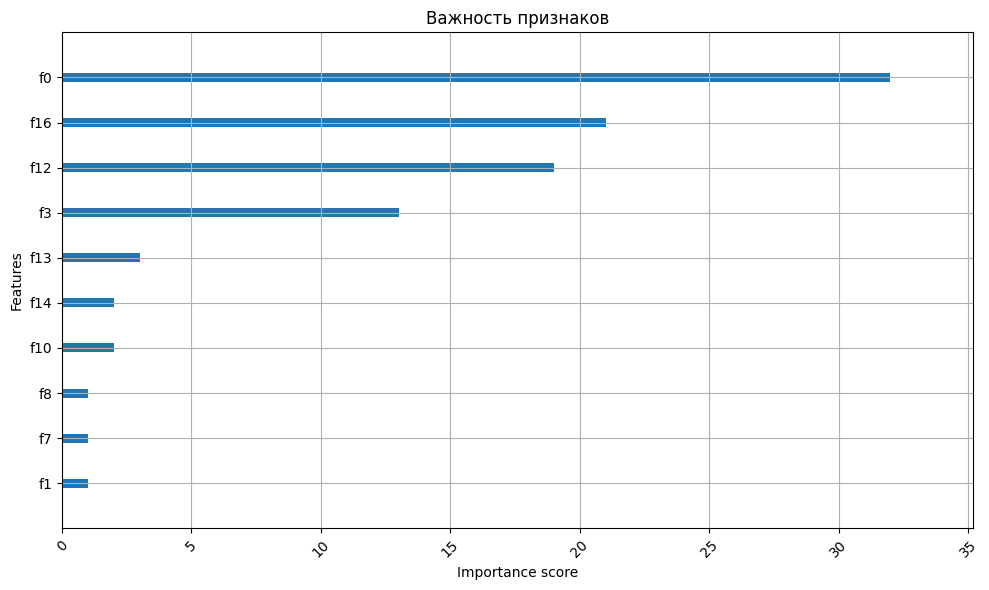

In [5]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Показываем важность признаков
feature_names = [
    'mean', 'std', 'max', 'min', 'ptp', 'energy', 'mean_abs',
    'center_mean', 'center_std', 'center_max', 'center_energy', 'center_vs_edges',
    'skew', 'kurtosis', 'jumps',
    'fft_max', 'fft_low', 'fft_mid', 'fft_high'
]

fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax, importance_type='weight', title="Важность признаков", show_values=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()